In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from matminer.utils.conversions import str_to_composition
from matminer.featurizers.composition import ElementProperty
from matminer.featurizers.composition import ElementFraction

In [2]:
df  = pd.read_pickle('../deliver/NIST_CeramicDataSet.pkl')

In [3]:
#check if the entry with B-N instead of BN will be a problem for flexural strength. answer: it doesn't have a flexural strength
df.loc[3892, 'Flexural Strength']

nan

## Looking at flexural strength

In [36]:
# New DataFrame containing only samples with a flexural strength value
fs = df[df.isnull()['Flexural Strength'] == False]
fs.shape

(484, 161)

In [37]:
# Check if all units are the same, in which case we don't need the units.
fs['Flexural Strength-units'].unique()

array(['MPa'], dtype=object)

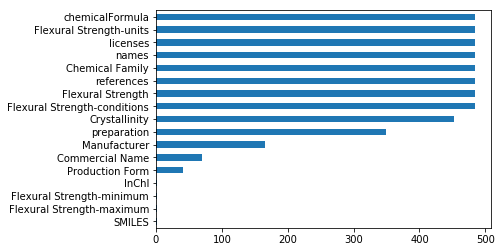

In [38]:
# Plot occurrence of features of the reduced dataset
fs.count().sort_values()[-17:].plot.barh()
plt.show()

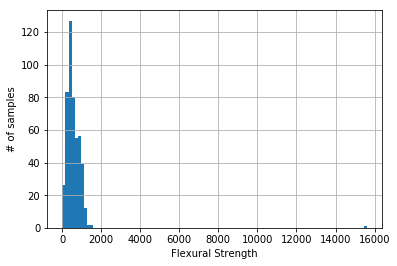

In [39]:
fsn = fs['Flexural Strength'].dropna()
fsn = pd.to_numeric(fsn, errors='coerce')
fsn.hist(bins=100)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

In [40]:
#we see above that one value is a huge outlier compared to all the others, which have a nice spread

In [41]:
# Drop all columns that contain less than 400 entries 
fs = fs.dropna(axis=1, thresh=400)
fs.head()

,chemicalFormula,licenses,names,references,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions,Flexural Strength-units
10,Si3N4.xY2O3.ySrO,[{'name': 'NIST_SRD-30'}],[Silicon nitride],[{'citation': 'Ceramic Technology Project Data...,"Si-N:SrO,Y",Polycrystalline,707,"[{'name': 'Temperature', 'scalars': [{'value':...",MPa
34,TiN,[{'name': 'NIST_SRD-30'}],[Titanium nitride],[{'citation': 'The Mechanical Properties of Ho...,Ti-N,Polycrystalline,167,"[{'name': 'Mass Fraction of Additive', 'scalar...",MPa
37,ZrO2.xMgO,[{'name': 'NIST_SRD-30'}],[Zirconia (PSZ)],[{'citation': 'Characterization Studies of Tra...,Zr-O:MgO,NaN,677,"[{'name': 'Temperature', 'scalars': [{'value':...",MPa
41,Al2O3.xZrO2,[{'name': 'NIST_SRD-30'}],[Alumina composite],[{'citation': 'Characterization Studies of Tra...,Al-O:ZrO,NaN,1265,"[{'name': 'Temperature', 'scalars': [{'value':...",MPa
44,ZrO2.xY2O3,[{'name': 'NIST_SRD-30'}],[Zirconia (TZP)],[{'citation': 'Evaluation of Japanese Yttria T...,Zr-O:Y,Polycrystalline,1045,"[{'name': 'Oxidation Temperature', 'scalars': ...",MPa


In [42]:
# Determine number of polycrystalline / single crystal samples
N_polyX = fs[fs['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = fs[fs['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (444,), Single crystal: (8,)


In [43]:
#Fill NaN values in crystallinity with polycrystalline:
fs['Crystallinity'] = fs['Crystallinity'].fillna('Polycrystalline')
N_polyX = fs[fs['Crystallinity']=='Polycrystalline']['Crystallinity'].shape
N_singleX = fs[fs['Crystallinity']=='Single Crystal']['Crystallinity'].shape
print('Polycrystalline: {0}, Single crystal: {1}'.format(N_polyX, N_singleX))

Polycrystalline: (476,), Single crystal: (8,)


In [44]:
# Check how many values cannot simply be transformed from string to int
#also locate which row the errors occur in

N_errors, N_total, row = 0, 0, -1
for entry in fs['Flexural Strength']:
    row+=1
    try:
        pd.Series([entry]).astype(float)
    except:
        N_errors +=1
        print(entry)
        print(row)
        
    finally:
        N_total +=1

print('{0} errors in {1} samples'.format(N_errors, N_total))

359 (15%)
295
1 errors in 484 samples


In [45]:
#examine the troublesome entry
fs.iloc[295]

chemicalFormula                                                               SiC
licenses                                                [{'name': 'NIST_SRD-30'}]
names                                                           [Silicon carbide]
references                      [{'citation': 'Material Properties of a Sinter...
Chemical Family                                                              Si-C
Crystallinity                                                     Polycrystalline
Flexural Strength                                                       359 (15%)
Flexural Strength-conditions    [{'name': 'Temperature', 'scalars': [{'value':...
Flexural Strength-units                                                       MPa
Name: 2451, dtype: object

In [46]:
#fix the troublesome entry
fs.set_value(2451, 'Flexural Strength', '359');
fs.loc[2451]

chemicalFormula                                                               SiC
licenses                                                [{'name': 'NIST_SRD-30'}]
names                                                           [Silicon carbide]
references                      [{'citation': 'Material Properties of a Sinter...
Chemical Family                                                              Si-C
Crystallinity                                                     Polycrystalline
Flexural Strength                                                             359
Flexural Strength-conditions    [{'name': 'Temperature', 'scalars': [{'value':...
Flexural Strength-units                                                       MPa
Name: 2451, dtype: object

In [47]:
#convert flex strength to a float and sort by it to confirm it is behaving properly as a float
fs['Flexural Strength'] = fs['Flexural Strength'].astype(float)
fs = fs.drop(['licenses','names','references','Flexural Strength-units',], axis=1)
fs.sort_values(by='Flexural Strength')

,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions
2486,C,C,Polycrystalline,20.0,"[{'name': 'Quality Index', 'scalars': [{'value..."
2312,3Al2O3.2SiO2,Al-Si-O,Polycrystalline,46.0,"[{'name': 'Relative Density', 'scalars': [{'va..."
562,ZrO2,Zr-O,Polycrystalline,50.0,"[{'name': 'Phase Composition', 'scalars': [{'v..."
1575,Y2O3.xZrO2,Y-O:ZrO,Polycrystalline,63.0,"[{'name': 'Sample Number', 'scalars': [{'value..."
510,MgAl2O4,Mg-Al-O,Polycrystalline,79.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
1090,BeO,Be-O,Polycrystalline,83.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
3526,Al2O3,Al-O,Polycrystalline,88.0,"[{'name': 'Flaw Size', 'scalars': [{'value': '..."
2196,3Al2O3.2SiO2.xZrO2,Al-Si-O:ZrO,Polycrystalline,100.0,"[{'name': 'Number of Shock Cycles', 'scalars':..."
3402,C,C,Polycrystalline,105.0,"[{'name': 'Specimen Condition', 'scalars': [{'..."
2452,Al2O3,Al-O,Polycrystalline,105.0,"[{'name': 'Pressing Pressure', 'scalars': [{'v..."


In [48]:
N_unique_entries = len(fs['chemicalFormula'].unique())
print('There are just {0} unique entries in the {1} materials.'.format(N_unique_entries,fs.shape[0]))

There are just 115 unique entries in the 484 materials.


In [49]:
#reset the index from the original data set to this reduced data set
fs = fs.reset_index()
fs.head()


,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions
0,10,Si3N4.xY2O3.ySrO,"Si-N:SrO,Y",Polycrystalline,707.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
1,34,TiN,Ti-N,Polycrystalline,167.0,"[{'name': 'Mass Fraction of Additive', 'scalar..."
2,37,ZrO2.xMgO,Zr-O:MgO,Polycrystalline,677.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
3,41,Al2O3.xZrO2,Al-O:ZrO,Polycrystalline,1265.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
4,44,ZrO2.xY2O3,Zr-O:Y,Polycrystalline,1045.0,"[{'name': 'Oxidation Temperature', 'scalars': ..."


In [50]:
#we get rid of the last row because the flexural strength is a huge outlier
fs.sort_values(by='Flexural Strength')
fs = fs.drop(fs.index[[427]])
fs.sort_values(by='Flexural Strength')

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions
301,2486,C,C,Polycrystalline,20.0,"[{'name': 'Quality Index', 'scalars': [{'value..."
273,2312,3Al2O3.2SiO2,Al-Si-O,Polycrystalline,46.0,"[{'name': 'Relative Density', 'scalars': [{'va..."
68,562,ZrO2,Zr-O,Polycrystalline,50.0,"[{'name': 'Phase Composition', 'scalars': [{'v..."
196,1575,Y2O3.xZrO2,Y-O:ZrO,Polycrystalline,63.0,"[{'name': 'Sample Number', 'scalars': [{'value..."
62,510,MgAl2O4,Mg-Al-O,Polycrystalline,79.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
130,1090,BeO,Be-O,Polycrystalline,83.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
408,3526,Al2O3,Al-O,Polycrystalline,88.0,"[{'name': 'Flaw Size', 'scalars': [{'value': '..."
256,2196,3Al2O3.2SiO2.xZrO2,Al-Si-O:ZrO,Polycrystalline,100.0,"[{'name': 'Number of Shock Cycles', 'scalars':..."
390,3402,C,C,Polycrystalline,105.0,"[{'name': 'Specimen Condition', 'scalars': [{'..."
296,2452,Al2O3,Al-O,Polycrystalline,105.0,"[{'name': 'Pressing Pressure', 'scalars': [{'v..."


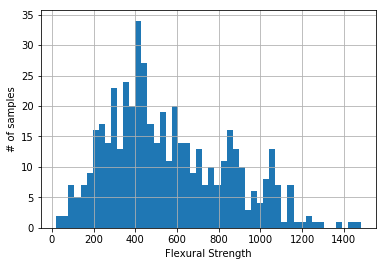

In [51]:
#look at the disribution of the data with the outlier removed
fsn1 = fs['Flexural Strength']
fsn1 = pd.to_numeric(fsn1, errors = 'coerce')
fsn1.hist(bins=50)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

In [52]:
#look at the duplicated entries by chemical formula. some chemicals are repeated only twice, others are repeated tens of times
fsd = fs[fs.duplicated('chemicalFormula', keep = False)]
fsd.groupby('chemicalFormula').count()

,index,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions
chemicalFormula,,,,,
3Al2O3.2SiO2,13,13,13,13,13
3Al2O3.2SiO2.xZrO2,2,2,2,2,2
Al2O3,27,27,27,27,27
Al2O3.xCeO2.yZrO2,5,5,5,5,5
Al2O3.xSiC,4,4,4,4,4
Al2O3.xZrO2,6,6,6,6,6
Al4+2xSi2-2xO10-x.yZrO2,3,3,3,3,3
AlN,8,8,8,8,8
AlN.xSiC,2,2,2,2,2


In [53]:
#Examine the repeated values for SiC
sic = fsd.loc[fsd['chemicalFormula'] == 'SiC']
sic

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions
6,52,SiC,Si-C,Polycrystalline,451.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
11,92,SiC,Si-C,Polycrystalline,184.0,"[{'name': 'C-ring Test Temperature', 'scalars'..."
21,187,SiC,Si-C,Polycrystalline,550.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
33,265,SiC,Si-C:Al,Polycrystalline,550.0,"[{'name': 'Number of Samples', 'scalars': [{'v..."
39,334,SiC,Si-C,Polycrystalline,437.0,"[{'name': 'Oxidation Time', 'scalars': [{'valu..."
41,351,SiC,Si-C:Al,Polycrystalline,940.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
49,431,SiC,Si-C,Polycrystalline,500.0,"[{'name': 'Range', 'scalars': [{'minimum': '30..."
50,432,SiC,Si-C,Polycrystalline,242.0,"[{'name': 'Exposure Temperature', 'scalars': [..."
65,539,SiC,Si-C,Polycrystalline,401.0,"[{'name': 'Temperature', 'scalars': [{'value':..."
70,565,SiC,Si-C,Polycrystalline,470.0,"[{'name': 'Temperature', 'scalars': [{'value':..."


In [75]:
sic.iloc[14]['Flexural Strength-conditions']

[{'name': 'Temperature',
  'scalars': [{'value': '25'}],
  'units': '$^{\\circ}$C'},
 {'name': 'Test Condition',
  'scalars': [{'value': 'A'}, {'value': 'B'}, {'value': 'C'}]}]

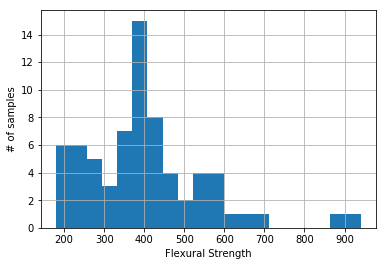

In [76]:
#Plot the repeated values for SiC
sic = fsd.loc[fsd['chemicalFormula'] == 'SiC']
sic1 = sic['Flexural Strength']
sic1.hist(bins=20)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

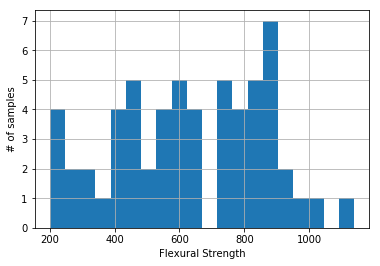

In [77]:
#Plot the repeated values for Si3N4
sin = fsd.loc[fsd['chemicalFormula'] == 'Si3N4']
sin1 = sin['Flexural Strength']
sin1.hist(bins=20)
plt.xlabel('Flexural Strength')
plt.ylabel('# of samples')
plt.show()

In [78]:
#initialize temp column
fs['Temperature'] = np.nan
fs.head()

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions,Temperature
0,10,Si3N4.xY2O3.ySrO,"Si-N:SrO,Y",Polycrystalline,707.0,"[{'name': 'Temperature', 'scalars': [{'value':...",NaN
1,34,TiN,Ti-N,Polycrystalline,167.0,"[{'name': 'Mass Fraction of Additive', 'scalar...",NaN
2,37,ZrO2.xMgO,Zr-O:MgO,Polycrystalline,677.0,"[{'name': 'Temperature', 'scalars': [{'value':...",NaN
3,41,Al2O3.xZrO2,Al-O:ZrO,Polycrystalline,1265.0,"[{'name': 'Temperature', 'scalars': [{'value':...",NaN
4,44,ZrO2.xY2O3,Zr-O:Y,Polycrystalline,1045.0,"[{'name': 'Oxidation Temperature', 'scalars': ...",NaN


In [80]:
#add values temperature column taken from flexural strength conditions
for mat in fs.index:
    for cond in fs.loc[mat]['Flexural Strength-conditions']:
        if cond['name']=='Temperature' and cond['units']=='$^{\\circ}$C' :
            fs.at[mat, 'Temperature']= cond['scalars'][0]['value']
fs.head()

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Flexural Strength-conditions,Temperature
0,10,Si3N4.xY2O3.ySrO,"Si-N:SrO,Y",Polycrystalline,707.0,"[{'name': 'Temperature', 'scalars': [{'value':...",25.0
1,34,TiN,Ti-N,Polycrystalline,167.0,"[{'name': 'Mass Fraction of Additive', 'scalar...",NaN
2,37,ZrO2.xMgO,Zr-O:MgO,Polycrystalline,677.0,"[{'name': 'Temperature', 'scalars': [{'value':...",25.0
3,41,Al2O3.xZrO2,Al-O:ZrO,Polycrystalline,1265.0,"[{'name': 'Temperature', 'scalars': [{'value':...",25.0
4,44,ZrO2.xY2O3,Zr-O:Y,Polycrystalline,1045.0,"[{'name': 'Oxidation Temperature', 'scalars': ...",NaN


In [81]:
fs.isnull().sum()
#181 out of the 483 entries do not have a temperature in celcius. 167 do not have a temperature at all

index                             0
chemicalFormula                   0
Chemical Family                   0
Crystallinity                     0
Flexural Strength                 0
Flexural Strength-conditions      0
Temperature                     181
dtype: int64

In [82]:
fs = fs.drop(['Flexural Strength-conditions',], axis=1)
fs.head()

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Temperature
0,10,Si3N4.xY2O3.ySrO,"Si-N:SrO,Y",Polycrystalline,707.0,25.0
1,34,TiN,Ti-N,Polycrystalline,167.0,NaN
2,37,ZrO2.xMgO,Zr-O:MgO,Polycrystalline,677.0,25.0
3,41,Al2O3.xZrO2,Al-O:ZrO,Polycrystalline,1265.0,25.0
4,44,ZrO2.xY2O3,Zr-O:Y,Polycrystalline,1045.0,NaN


In [83]:
fs['Temperature'] = fs['Temperature'].fillna(23)
fs

,index,chemicalFormula,Chemical Family,Crystallinity,Flexural Strength,Temperature
0,10,Si3N4.xY2O3.ySrO,"Si-N:SrO,Y",Polycrystalline,707.0,25.0
1,34,TiN,Ti-N,Polycrystalline,167.0,23.0
2,37,ZrO2.xMgO,Zr-O:MgO,Polycrystalline,677.0,25.0
3,41,Al2O3.xZrO2,Al-O:ZrO,Polycrystalline,1265.0,25.0
4,44,ZrO2.xY2O3,Zr-O:Y,Polycrystalline,1045.0,23.0
5,47,SiC.xB4C,Si-C:B,Polycrystalline,745.0,22.0
6,52,SiC,Si-C,Polycrystalline,451.0,22.0
7,54,Si3N4.xY2O3.yAl2O3,Si-N:Al,Polycrystalline,598.0,25.0
8,82,Si3N4.xY2O3.yLaO2.zAl2O3,Si-N:Al,Polycrystalline,883.0,22.0
9,83,C,C,Polycrystalline,420.0,23.0


In [84]:
fsg = fs.groupby(['chemicalFormula','Crystallinity', 'Temperature'], as_index=False).mean()
fsg

,chemicalFormula,Crystallinity,Temperature,index,Flexural Strength
0,$\beta$-Si3Al3O3N5,Polycrystalline,23.0,175.000000,455.000000
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,23.0,2575.000000,380.000000
2,3Al2O3.2SiO2,Polycrystalline,20.0,1464.000000,223.000000
3,3Al2O3.2SiO2,Polycrystalline,23.0,2321.090909,266.363636
4,3Al2O3.2SiO2,Polycrystalline,50.0,1032.000000,300.000000
5,3Al2O3.2SiO2.xSiC,Polycrystalline,23.0,1070.000000,366.000000
6,3Al2O3.2SiO2.xZrO2,Polycrystalline,23.0,2760.500000,200.000000
7,3Al2O3.2SiO3.2ZrO2,Polycrystalline,23.0,787.000000,400.000000
8,AL2O3,Polycrystalline,23.0,1431.000000,200.000000
9,Al2O3,Polycrystalline,20.0,1295.666667,392.000000


In [95]:
fsg.at[8,'chemicalFormula' ] = 'Al2O3'
fsg.at[8,'chemicalFormula' ]

'Al2O3'

In [96]:
fsg1 = fsg.copy()

# Parse the chemicalFormula
def formula_decompose(formula):
    '''
    decompose chemical formula 
    return
        composition: list, [(element,num),...]
            element: string
            num: string, can be math expression such as '1+0.5x'
    '''

    comp = []
    p = re.compile(r'(\d?[w-z]?)([A-Z][a-u]?)(\d*\+?\-?\d*\.?\d*[w-z]?)')

    #split the chemical formula if there is dots, but not for cases like Mg1.5x
    if re.search(r'\.', formula) and not re.search(r'\d+\.\d[w-z]', formula): 
        formula = formula.split('.')
        for item in formula:
            prefactor = '1'
            for i in re.findall(p, item):
                pre, elem, num = i
                if pre:
                    prefactor = pre
                if num == '':
                    num = '1'
                num = prefactor + '*({})'.format(num)
                comp.append((elem, num))
    else:
        prefactor = '1'
        for i in re.findall(p, formula):
            pre, elem, num = i
            if pre:
                prefactor = pre
            if num == '':
                num = '1'
            num = prefactor + '*({})'.format(num)
            comp.append((elem, num))
    return comp 

def formula_reconstruct(composition, x=0.1, y=0.1, z=0.1, w=0.1):
    '''
    reconstruct chemical formula from composition
    composition in form of [(element,num), (element,num),...]
        element: string
        num: string, can be math expression such as '1+0.5x'

    return 
        flat chemcial formula: string, such as 'Ti1.5Cu0.1Au1.0'
    '''
    flat_list = []
    for (elem, num) in composition:
        num = re.sub(r'(\d)([w-z])', r'\1*\2', num) #convert 5x to 5*x
        flat_list.append(elem)
        flat_list.append(format(eval(num), '.1f'))
    return ''.join(flat_list)
  
def formula_parser(formula):
    return formula_reconstruct(formula_decompose(formula))

In [97]:
fsg1["flatFormula"] = fsg1["chemicalFormula"].map(formula_parser)
fsg1.dropna(axis=1).head()

,chemicalFormula,Crystallinity,Temperature,index,Flexural Strength,flatFormula
0,$\beta$-Si3Al3O3N5,Polycrystalline,23.0,175.000000,455.000000,Si3.0Al3.0O3.0N5.0
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,23.0,2575.000000,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1
2,3Al2O3.2SiO2,Polycrystalline,20.0,1464.000000,223.000000,Al6.0O9.0Si2.0O4.0
3,3Al2O3.2SiO2,Polycrystalline,23.0,2321.090909,266.363636,Al6.0O9.0Si2.0O4.0
4,3Al2O3.2SiO2,Polycrystalline,50.0,1032.000000,300.000000,Al6.0O9.0Si2.0O4.0


In [98]:
fsg1["composition"] =fsg1["flatFormula"].transform(str_to_composition)
fsg1.dropna(axis=1).head()

,chemicalFormula,Crystallinity,Temperature,index,Flexural Strength,flatFormula,composition
0,$\beta$-Si3Al3O3N5,Polycrystalline,23.0,175.000000,455.000000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)"
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,23.0,2575.000000,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)"
2,3Al2O3.2SiO2,Polycrystalline,20.0,1464.000000,223.000000,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)"
3,3Al2O3.2SiO2,Polycrystalline,23.0,2321.090909,266.363636,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)"
4,3Al2O3.2SiO2,Polycrystalline,50.0,1032.000000,300.000000,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)"


In [99]:
print(len(fsg1['composition'].unique()))
print(len(fsg1['chemicalFormula'].unique()))

112
114


In [114]:
#we see some issues with chemical formula and composition since there isn't the same number of unique values? maybe it's ok
pd.options.display.max_rows = 1000
fsg1
fsg1.sort_values(by = 'composition')

,chemicalFormula,Crystallinity,Temperature,index,Flexural Strength,flatFormula,composition
47,C,Polycrystalline,23.0,2302.500000,658.214286,C1.0,(C)
38,B4C,Polycrystalline,25.0,2476.000000,375.000000,B4.0C1.0,"(B, C)"
37,B4C,Polycrystalline,23.0,1831.000000,342.000000,B4.0C1.0,"(B, C)"
36,B4C,Polycrystalline,20.0,3318.000000,312.000000,B4.0C1.0,"(B, C)"
41,B4C.xSiC,Polycrystalline,23.0,3932.000000,455.000000,B4.0C1.0Si0.1C0.1,"(B, C, Si)"
119,SiC,Polycrystalline,20.0,2559.100000,449.600000,Si1.0C1.0,"(Si, C)"
124,SiC,Polycrystalline,1200.0,2329.500000,369.000000,Si1.0C1.0,"(Si, C)"
120,SiC,Polycrystalline,22.0,1896.933333,378.933333,Si1.0C1.0,"(Si, C)"
121,SiC,Polycrystalline,23.0,1975.034483,382.413793,Si1.0C1.0,"(Si, C)"
122,SiC,Polycrystalline,25.0,1700.333333,448.333333,Si1.0C1.0,"(Si, C)"


In [115]:
fsg2 = fsg1[fsg1.duplicated('chemicalFormula', keep = False)]
fsg2.shape

(98, 7)

In [116]:
fsg2 = fsg1[fsg1.duplicated('composition', keep = False)]
fsg2.shape

(99, 7)

## featurizing

In [117]:
fs_feat = fsg1.copy() # Create new DataFrame for featurization

In [118]:
# Add features with matminer (using the floating point composition by Chih-Hao)
ep_feat = ElementProperty.from_preset(preset_name="magpie")
fs_feat = ep_feat.featurize_dataframe(fs_feat, col_id="composition", ignore_errors=True)

In [119]:
fs_feat.shape

(180, 139)

In [120]:
# List of the new columns
list(set(fs_feat.columns) ^ set(fs.columns))[:10]

['avg_dev GSvolume_pa',
 'mode MendeleevNumber',
 'range AtomicWeight',
 'mean NsValence',
 'minimum GSvolume_pa',
 'composition',
 'minimum MendeleevNumber',
 'mode MeltingT',
 'range Column',
 'range NValence']

In [121]:
fs_feat.head()

,chemicalFormula,Crystallinity,Temperature,index,Flexural Strength,flatFormula,composition,minimum Number,maximum Number,range Number,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
0,$\beta$-Si3Al3O3N5,Polycrystalline,23.0,175.000000,455.000000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)",7.0,14.0,7.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,12.0,227.0,215.0,168.714286,67.163265,194.0
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,23.0,2575.000000,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)",7.0,22.0,15.0,...,0.000023,4.172840e-07,8.191129e-07,0.0,12.0,225.0,213.0,104.944444,103.271605,12.0
2,3Al2O3.2SiO2,Polycrystalline,20.0,1464.000000,223.000000,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)",8.0,14.0,6.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,12.0,227.0,215.0,93.333333,100.698413,12.0
3,3Al2O3.2SiO2,Polycrystalline,23.0,2321.090909,266.363636,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)",8.0,14.0,6.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,12.0,227.0,215.0,93.333333,100.698413,12.0
4,3Al2O3.2SiO2,Polycrystalline,50.0,1032.000000,300.000000,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)",8.0,14.0,6.0,...,0.000000,0.000000e+00,0.000000e+00,0.0,12.0,227.0,215.0,93.333333,100.698413,12.0


In [122]:
# Adds a column for every element. Values are fraction of atoms that belong to that element.
ep_frac = ElementFraction()
fs_feat = ep_frac.featurize_dataframe(fs_feat, col_id = "composition", ignore_errors = True)
fs_feat.head()

,chemicalFormula,Crystallinity,Temperature,index,Flexural Strength,flatFormula,composition,minimum Number,maximum Number,range Number,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,$\beta$-Si3Al3O3N5,Polycrystalline,23.0,175.000000,455.000000,Si3.0Al3.0O3.0N5.0,"(Si, Al, O, N)",7.0,14.0,7.0,...,0,0,0,0,0,0,0,0,0,0
1,(1-x-y)Al2O3.xAlN.yTiN,Polycrystalline,23.0,2575.000000,380.000000,Al2.0O3.0Al0.1N0.1Ti0.1N0.1,"(Al, O, N, Ti)",7.0,22.0,15.0,...,0,0,0,0,0,0,0,0,0,0
2,3Al2O3.2SiO2,Polycrystalline,20.0,1464.000000,223.000000,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)",8.0,14.0,6.0,...,0,0,0,0,0,0,0,0,0,0
3,3Al2O3.2SiO2,Polycrystalline,23.0,2321.090909,266.363636,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)",8.0,14.0,6.0,...,0,0,0,0,0,0,0,0,0,0
4,3Al2O3.2SiO2,Polycrystalline,50.0,1032.000000,300.000000,Al6.0O9.0Si2.0O4.0,"(Al, O, Si)",8.0,14.0,6.0,...,0,0,0,0,0,0,0,0,0,0
